### READ ME

READ ME


Please read the instructions carefully before using this Repo or Python notebook


1. Use appropriate packages [change packages in the code] depending on the IDE running this Python notebook.
2. Raw Data is in .xlsx format in the same Repo.
3. This Python notebook was created and ran in Google Colab initially.
4. If you are running this notebook in Jupyter or other IDE, change the code that loads data, identify the appropriate packages and change the code according to the IDE.


### Import Packages and Download raw Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import statsmodels.api as sm
import textwrap

### ignore warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [2]:
#### Download and Pre-process data

from google.colab import drive
drive.mount('/content/drive')

bio = pd.read_excel('/content/drive/MyDrive/AAA 2025/Stats- asses/biomarkers.xlsx')
bio.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Biomarker   347 non-null    object 
 1   IL-8        347 non-null    float64
 2   VEGF-A      347 non-null    float64
 3   OPG         347 non-null    float64
 4   TGF-beta-1  347 non-null    float64
 5   IL-6        347 non-null    float64
 6   CXCL9       347 non-null    float64
 7   CXCL1       347 non-null    float64
 8   IL-18       347 non-null    float64
 9   CSF-1       347 non-null    float64
dtypes: float64(9), object(1)
memory usage: 27.2+ KB


In [3]:
covar = pd.read_excel('/content/drive/MyDrive/AAA 2025/Stats- asses/covariates.xlsx')
covar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               118 non-null    int64  
 1   Age                     118 non-null    int64  
 2   Sex (1=male, 2=female)  118 non-null    int64  
 3   Smoker (1=yes, 2=no)    118 non-null    int64  
 4   VAS-at-inclusion        118 non-null    float64
 5   Vas-12months            116 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 5.7 KB


### Test1 - statistical hypothesis tetsing - ALL biomarkers

#### Data pre-process

In [6]:
##### Extract patient ID from Biomarker ID. Using regular expression packages.

def extract_p_id(x):
  match = re.match(r'^\d+', x)
  if match:
    return int(match.group(0))
  return None

bio['patient_id'] = bio['Biomarker'].apply(extract_p_id)
bio.head(2)

,Biomarker,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,patient_id
0,126-0weeks,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41,126
1,126-6weeks,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39,126


In [7]:
##### Extract the Biomarker time in to a new column 0weeks = '0weeks', 6weeks = '6weeks' and 12months = '12months'

def extract_time(x):
  return x.split('-')[-1]

bio['biomarker_time'] = bio['Biomarker'].apply(extract_time)
bio.head()

,Biomarker,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,patient_id,biomarker_time
0,126-0weeks,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41,126,0weeks
1,126-6weeks,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39,126,6weeks
2,127-0weeks,6.93,10.92,10.30,6.59,2.73,6.14,7.31,7.95,8.40,127,0weeks
3,127-6weeks,7.16,11.58,10.39,8.61,2.60,6.35,8.61,7.94,8.51,127,6weeks
4,127-12months,6.87,11.13,10.25,7.44,3.92,6.15,8.79,7.94,8.46,127,12months


In [8]:
#### Replace column name in covariates
covar.columns = ['patient_id', 'age' ,'sex', 'smoker', 'vas_at_inclusion', 'vas_12months']
covar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        118 non-null    int64  
 1   age               118 non-null    int64  
 2   sex               118 non-null    int64  
 3   smoker            118 non-null    int64  
 4   vas_at_inclusion  118 non-null    float64
 5   vas_12months      116 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 5.7 KB


In [9]:

##### Number of patients (unique ID) in each data sets

print(f" Number of unique Patient IDs in Biomarker data : {bio['patient_id'].nunique()}")
print(f" Number of unique Patient IDs in covariates data : {covar['patient_id'].nunique()}")


#### Merge both datasets using patient_id

merged_data = pd.merge(bio, covar, on='patient_id')
merged_data.head(2)

 Number of unique Patient IDs in Biomarker data : 118
 Number of unique Patient IDs in covariates data : 118


,Biomarker,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,patient_id,biomarker_time,age,sex,smoker,vas_at_inclusion,vas_12months
0,126-0weeks,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41,126,0weeks,41,2,1,6.5,0.0
1,126-6weeks,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39,126,6weeks,41,2,1,6.5,0.0


In [10]:
##### Do all patient_id have biomarkers at inclusion?

print(f"Unique number of patient IDs with biomarker at inclusion : {merged_data[merged_data['biomarker_time'] =='0weeks']['patient_id'].nunique()}")


Unique number of patient IDs with biomarker at inclusion : 117


In [11]:

#### Find the missing patient ID - missing biomarker reading at inclusion [0weeks]

at_inclusion_patients = (merged_data[merged_data['biomarker_time'] =='0weeks']['patient_id']).to_list()
all_patients = (merged_data['patient_id']).to_list()

missing_ids_set = set([id for id in all_patients if id not in at_inclusion_patients])
# Convert the set to a list and extract the first element
missing_patient_id = list(missing_ids_set)[0]

print(f"missing patient ID : {missing_patient_id}")

missing patient ID : 40


In [12]:
##### Filter out data for Statistical Hypothesis testing
##### To answer Q1 : do the levels at inclusion (0weeks) vary between males and females?

##### Only need the patient ID, sex, and all biomarkers at inclusion.

test1 = merged_data[merged_data['biomarker_time'] =='0weeks'][['patient_id', 'sex',
                                                               'IL-8', 'VEGF-A', 'OPG',
                                                               'TGF-beta-1', 'IL-6', 'CXCL9',
                                                               'CXCL1', 'IL-18', 'CSF-1'
                                                               ]]

test1.head(2)

,patient_id,sex,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1
0,126,2,7.63,11.51,10.2,8.83,3.52,6.16,9.45,7.91,8.41
2,127,1,6.93,10.92,10.3,6.59,2.73,6.14,7.31,7.95,8.40


Checking for invalid (≤0 or non-finite) biomarker values
IL-8: OK (all positive and finite)
VEGF-A: OK (all positive and finite)
OPG: OK (all positive and finite)
TGF-beta-1: OK (all positive and finite)
IL-6: OK (all positive and finite)
CXCL9: OK (all positive and finite)
CXCL1: OK (all positive and finite)
IL-18: OK (all positive and finite)
CSF-1: OK (all positive and finite)

Number of duplicate patient IDs: 0
 ✅ No duplicate patient IDs detected.

Summary statistics for biomarkers 


,count,mean,std,min,25%,50%,75%,max
IL-8,117.0,7.719060,0.887939,5.50,7.01,7.78,8.29,11.33
VEGF-A,117.0,11.875385,0.668744,10.60,11.38,11.80,12.42,13.51
OPG,117.0,10.728803,0.422181,9.67,10.48,10.66,10.91,11.85
TGF-beta-1,117.0,8.243077,0.935001,6.55,7.47,8.43,9.00,9.91
IL-6,117.0,3.334786,0.993196,1.81,2.64,3.08,3.76,7.91
CXCL9,117.0,6.624872,0.897312,5.25,6.11,6.56,6.98,11.51
CXCL1,117.0,8.671368,1.233398,6.17,7.66,9.07,9.60,11.19
IL-18,117.0,8.370598,0.600823,6.89,7.98,8.35,8.74,9.78
CSF-1,117.0,8.598803,0.287042,7.95,8.39,8.56,8.75,9.78


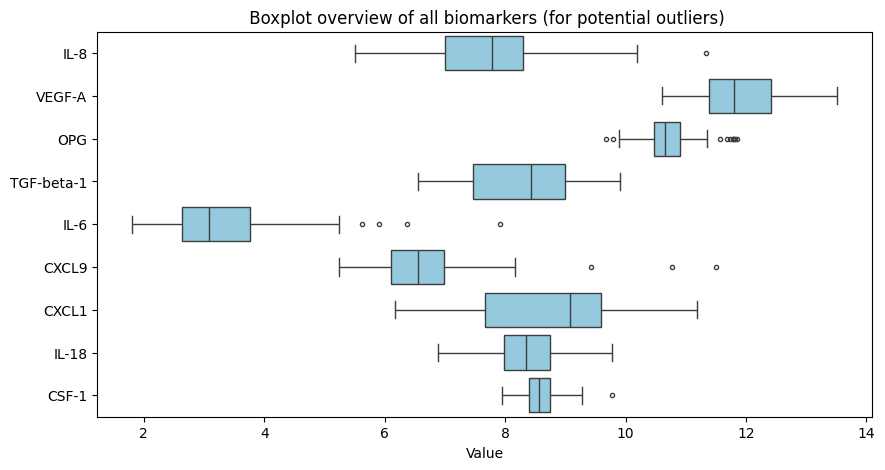

In [13]:

#### Further Data checks

df = test1.copy()

biomarkers = ['IL-8','VEGF-A','OPG','TGF-beta-1','IL-6','CXCL9','CXCL1','IL-18','CSF-1']

print("Checking for invalid (≤0 or non-finite) biomarker values")
for b in biomarkers:
    invalid_mask = (df[b] <= 0) | (~np.isfinite(df[b]))
    invalid_count = invalid_mask.sum()
    if invalid_count > 0:
        print(f"{b}: {invalid_count} invalid values found → inspect before analysis")
    else:
        print(f"{b}: OK (all positive and finite)")
print()


# Check for duplicate patient IDs

duplicates = df['patient_id'].duplicated().sum()
print(f"Number of duplicate patient IDs: {duplicates}")
if duplicates > 0:
    print("⚠️  Duplicates detected. verify patient_id entries before continuing.\n")
else:
    print(" ✅ No duplicate patient IDs detected.\n")


# Basic descriptive statistics & outlier scan
print("Summary statistics for biomarkers ")
display(df[biomarkers].describe().T)

# Boxplot overview (quick visual check for outliers)
plt.figure(figsize=(10,5))
sns.boxplot(data=df[biomarkers], orient='h', color='skyblue', fliersize=3)
plt.title(" Boxplot overview of all biomarkers (for potential outliers)")
plt.xlabel("Value")
plt.show()


#### Statistical Hypothesis test

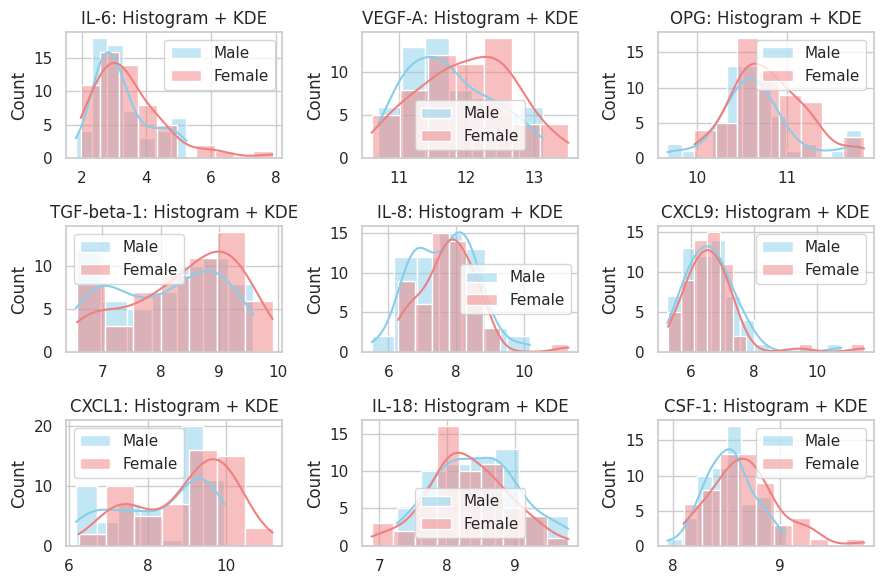

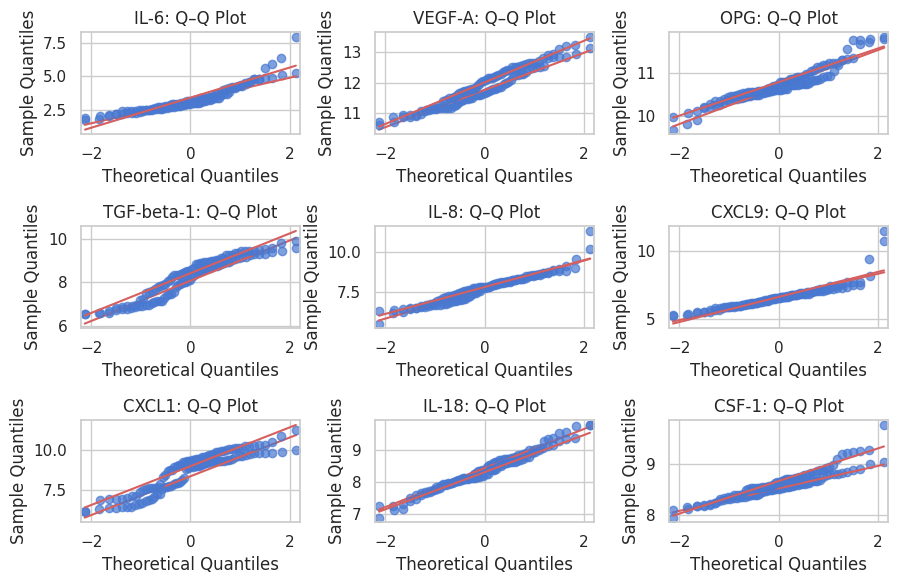

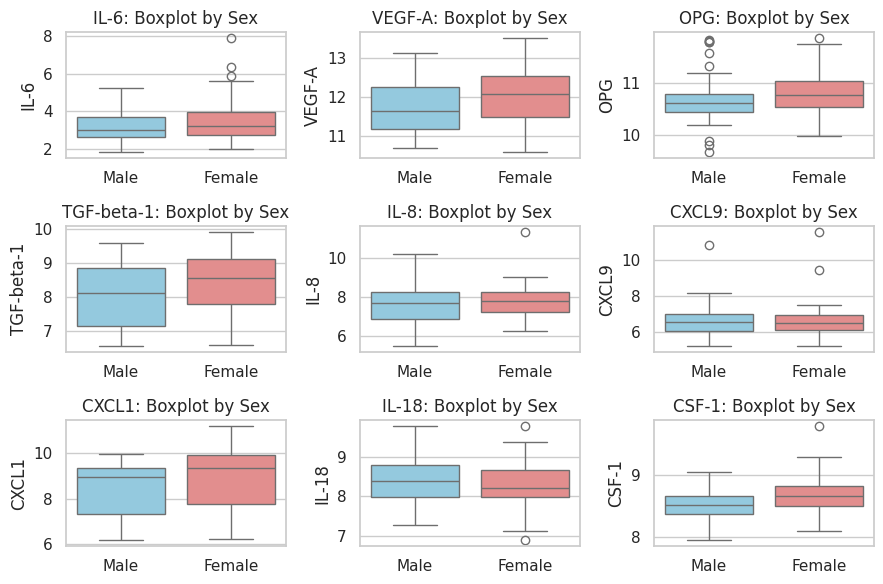



FINAL STATISTICAL SUMMARY FOR ALL BIOMARKERS

BIOMARKER: IL-6
Test Used: Mann–Whitney U Test (non-parametric)
Shapiro–Wilk p-values: Male=0.0005, Female=0.0000
Levene’s p-value: 0.2906
Main Test p-value: 0.3597
Confidence Interval: Not applicable (non-parametric).
Conclusion: No significant difference

Summary: Summary for IL-6: Both groups failed the normality test. Levene’s test
(p=0.2906) indicated equal variances. Because the normality assumption was
violated, a non-parametric Mann–Whitney U test was used to compare the
distributional locations between males and females. The p-value (0.3597) ≥ α =
0.05, so H₀ was not rejected. This indicates no statistically significant
difference in IL-6 levels between males and females. Overall, the evidence does
not support that IL-6 levels vary significantly between males and females.

BIOMARKER: VEGF-A
Test Used: Mann–Whitney U Test (non-parametric)
Shapiro–Wilk p-values: Male=0.0387, Female=0.6825
Levene’s p-value: 0.3401
Main Test p-value:

In [14]:

alpha = 0.05
biomarkers = ['IL-6', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-8',
              'CXCL9', 'CXCL1', 'IL-18', 'CSF-1']

# Dictionary-based explanations for tests
test_descriptions = {
    "Mann–Whitney U Test (non-parametric)": (
        "Because the normality assumption was violated, a non-parametric Mann–Whitney U test "
        "was used to compare the distributional locations between males and females."
    ),
    "Welch’s t-Test (unequal variances)": (
        "Given the unequal variances, Welch’s t-test was applied to compare the group means "
        "without assuming homogeneity of variance."
    ),
    "Student’s t-Test (equal variances)": (
        "As both normality and equal variance assumptions were met, a standard two-sample "
        "Student’s t-test was used to compare mean biomarker levels between the groups."
    )
}

results = []


### Step1: Run tests and store results
for biomarker in biomarkers:
    male = df.loc[df['sex'] == 1, biomarker]
    female = df.loc[df['sex'] == 2, biomarker]

    ## Normality
    p_shapiro_m = stats.shapiro(male)[1]
    p_shapiro_f = stats.shapiro(female)[1]
    p_dagostino_m = stats.normaltest(male)[1] if len(male) >= 8 else np.nan
    p_dagostino_f = stats.normaltest(female)[1] if len(female) >= 8 else np.nan
    normality = (p_shapiro_m >= alpha) and (p_shapiro_f >= alpha)

    # Variance
    p_levene = stats.levene(male, female)[1]
    equal_var = p_levene >= alpha

    ## Test selection
    if normality:
        if equal_var:
            test_name = "Student’s t-Test (equal variances)"
            stat, p_val = stats.ttest_ind(male, female, equal_var=True)
        else:
            test_name = "Welch’s t-Test (unequal variances)"
            stat, p_val = stats.ttest_ind(male, female, equal_var=False)
    else:
        test_name = "Mann–Whitney U Test (non-parametric)"
        stat, p_val = stats.mannwhitneyu(male, female, alternative='two-sided')

    ## Confidence interval (if applicable)
    mean_m, mean_f = male.mean(), female.mean()
    var_m, var_f = male.var(ddof=1), female.var(ddof=1)
    n1, n2 = len(male), len(female)
    mean_diff = mean_m - mean_f

    if "t-Test" in test_name:
        se_diff = np.sqrt(var_m/n1 + var_f/n2)
        df_approx = min(n1 - 1, n2 - 1)
        ci_low, ci_high = stats.t.interval(0.95, df=df_approx, loc=mean_diff, scale=se_diff)
        ci_text = f"95% CI: ({ci_low:.3f}, {ci_high:.3f})"
    else:
        ci_low = ci_high = np.nan
        ci_text = "Not applicable (non-parametric)."

    ### Summary logic
    if (p_shapiro_m < alpha) and (p_shapiro_f < alpha):
        norm_desc = "Both groups failed the normality test."
    elif (p_shapiro_m < alpha) and (p_shapiro_f >= alpha):
        norm_desc = "Male data violated normality, while female data were approximately normal."
    elif (p_shapiro_m >= alpha) and (p_shapiro_f < alpha):
        norm_desc = "Female data violated normality, while male data were approximately normal."
    else:
        norm_desc = "Both groups met the normality assumption."

    var_desc = f"Levene’s test (p={p_levene:.4f}) indicated {'equal' if equal_var else 'unequal'} variances."

    method_desc = test_descriptions.get(test_name, "Appropriate test selected based on assumptions.")

    if p_val < alpha:
        conclusion_text = (
            f"The p-value ({p_val:.4f}) < α = 0.05, so H₀ was rejected. "
            f"This indicates a statistically significant difference in {biomarker} levels between males and females."
        )
    else:
        conclusion_text = (
            f"The p-value ({p_val:.4f}) ≥ α = 0.05, so H₀ was not rejected. "
            f"This indicates no statistically significant difference in {biomarker} levels between males and females."
        )

    final_conclusion = (
        f"Summary for {biomarker}: {norm_desc} {var_desc} {method_desc} {conclusion_text} "
        f"Overall, the evidence does {'not ' if p_val >= alpha else ''}support that {biomarker} levels vary significantly "
        "between males and females."
    )

    results.append({
        'Biomarker': biomarker,
        'Test Used': test_name,
        'Shapiro_Male_p': p_shapiro_m,
        'Shapiro_Female_p': p_shapiro_f,
        'Levene_p': p_levene,
        'p_value': p_val,
        'CI': ci_text,
        'Conclusion': "Significant difference" if p_val < alpha else "No significant difference",
        'Summary': final_conclusion
    })

## Convert results to DataFrame for summary output
results_df = pd.DataFrame(results)


##### Step 2 : Visualization Grids

sns.set(style="whitegrid", palette="muted", font_scale=1.0)

### Histogram + KDE
fig, axes = plt.subplots(3, 3, figsize=(9, 6))
axes = axes.flatten()
for i, biomarker in enumerate(biomarkers):
    male = df.loc[df['sex'] == 1, biomarker]
    female = df.loc[df['sex'] == 2, biomarker]
    sns.histplot(male, kde=True, color='skyblue', ax=axes[i], label='Male')
    sns.histplot(female, kde=True, color='lightcoral', ax=axes[i], label='Female')
    axes[i].set_title(f"{biomarker}: Histogram + KDE")
    axes[i].legend()
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()

#  Q–Q Plots
fig, axes = plt.subplots(3, 3, figsize=(9, 6))
axes = axes.flatten()
for i, biomarker in enumerate(biomarkers):
    male = df.loc[df['sex'] == 1, biomarker]
    female = df.loc[df['sex'] == 2, biomarker]
    sm.qqplot(male, line='s', ax=axes[i], color='skyblue', alpha=0.7)
    sm.qqplot(female, line='s', ax=axes[i], color='lightcoral', alpha=0.7)
    axes[i].set_title(f"{biomarker}: Q–Q Plot")
plt.tight_layout()
plt.show()

## Boxplots
fig, axes = plt.subplots(3, 3, figsize=(9, 6))
axes = axes.flatten()
for i, biomarker in enumerate(biomarkers):
    sns.boxplot(x='sex', y=biomarker, data=df, hue='sex',
                palette={1:'skyblue',2:'lightcoral'}, legend=False, ax=axes[i])
    axes[i].set_title(f"{biomarker}: Boxplot by Sex")
    axes[i].set_xlabel('Sex')
    axes[i].set_ylabel(biomarker)
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['Male','Female'])
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()


# Step 3 : Print Final Summary

print("\n\nFINAL STATISTICAL SUMMARY FOR ALL BIOMARKERS\n")
for _, row in results_df.iterrows():
    print(f"{'='*90}")
    print(f"BIOMARKER: {row['Biomarker']}")
    print(f"Test Used: {row['Test Used']}")
    print(f"Shapiro–Wilk p-values: Male={row['Shapiro_Male_p']:.4f}, Female={row['Shapiro_Female_p']:.4f}")
    print(f"Levene’s p-value: {row['Levene_p']:.4f}")
    print(f"Main Test p-value: {row['p_value']:.4f}")
    print(f"Confidence Interval: {row['CI']}")
    wrapped_conclusion = textwrap.fill(row['Conclusion'], width=80)
    print(f"Conclusion: {wrapped_conclusion}")
    wrapped_summary = textwrap.fill(row['Summary'], width=80)
    print(f"\nSummary: {wrapped_summary}\n")



## Test2:  Regression modelling

In [15]:
#### Download and Pre-process data
from google.colab import drive
drive.mount('/content/drive')

bio = pd.read_excel('/content/drive/MyDrive/AAA 2025/Stats- asses/biomarkers.xlsx')
bio.info()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Biomarker   347 non-null    object 
 1   IL-8        347 non-null    float64
 2   VEGF-A      347 non-null    float64
 3   OPG         347 non-null    float64
 4   TGF-beta-1  347 non-null    float64
 5   IL-6        347 non-null    float64
 6   CXCL9       347 non-null    float64
 7   CXCL1       347 non-null    float64
 8   IL-18       347 non-null    float64
 9   CSF-1       347 non-null    float64
dtypes: float64(9), object(1)
memory usage: 27.2+ KB


In [16]:
covar = pd.read_excel('/content/drive/MyDrive/AAA 2025/Stats- asses/covariates.xlsx')
covar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               118 non-null    int64  
 1   Age                     118 non-null    int64  
 2   Sex (1=male, 2=female)  118 non-null    int64  
 3   Smoker (1=yes, 2=no)    118 non-null    int64  
 4   VAS-at-inclusion        118 non-null    float64
 5   Vas-12months            116 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 5.7 KB


In [17]:
##### Extract patient ID from Biomarker ID. Using regular expression packages.

def extract_p_id(x):
  match = re.match(r'^\d+', x)
  if match:
    return int(match.group(0))
  return None

bio['patient_id'] = bio['Biomarker'].apply(extract_p_id)
bio.head(2)

,Biomarker,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,patient_id
0,126-0weeks,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41,126
1,126-6weeks,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39,126


In [18]:
##### Extract the Biomarker time in to a new column 0weeks = '0weeks', 6weeks = '6weeks' and 12months = '12months'

def extract_time(x):
  return x.split('-')[-1]

bio['biomarker_time'] = bio['Biomarker'].apply(extract_time)
bio.head()

,Biomarker,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,patient_id,biomarker_time
0,126-0weeks,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41,126,0weeks
1,126-6weeks,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39,126,6weeks
2,127-0weeks,6.93,10.92,10.30,6.59,2.73,6.14,7.31,7.95,8.40,127,0weeks
3,127-6weeks,7.16,11.58,10.39,8.61,2.60,6.35,8.61,7.94,8.51,127,6weeks
4,127-12months,6.87,11.13,10.25,7.44,3.92,6.15,8.79,7.94,8.46,127,12months


In [19]:
#### Replace column name in covariates
covar.columns = ['patient_id', 'age' ,'sex', 'smoker', 'vas_at_inclusion', 'vas_12months']
covar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        118 non-null    int64  
 1   age               118 non-null    int64  
 2   sex               118 non-null    int64  
 3   smoker            118 non-null    int64  
 4   vas_at_inclusion  118 non-null    float64
 5   vas_12months      116 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 5.7 KB


In [20]:
#### Join biomarkers at inclusion data with covariates

bio_at_inclusion = bio[bio['biomarker_time'] == '0weeks']
bio_at_inclusion.shape

(117, 12)

In [21]:
reg_test = pd.merge(bio_at_inclusion, covar, on='patient_id')
reg_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Biomarker         117 non-null    object 
 1   IL-8              117 non-null    float64
 2   VEGF-A            117 non-null    float64
 3   OPG               117 non-null    float64
 4   TGF-beta-1        117 non-null    float64
 5   IL-6              117 non-null    float64
 6   CXCL9             117 non-null    float64
 7   CXCL1             117 non-null    float64
 8   IL-18             117 non-null    float64
 9   CSF-1             117 non-null    float64
 10  patient_id        117 non-null    int64  
 11  biomarker_time    117 non-null    object 
 12  age               117 non-null    int64  
 13  sex               117 non-null    int64  
 14  smoker            117 non-null    int64  
 15  vas_at_inclusion  117 non-null    float64
 16  vas_12months      115 non-null    float64
dt

In [22]:
#### missing vas_12months for 2 patients, these will be dropped
reg_test_final = reg_test.dropna()
reg_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 0 to 116
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Biomarker         115 non-null    object 
 1   IL-8              115 non-null    float64
 2   VEGF-A            115 non-null    float64
 3   OPG               115 non-null    float64
 4   TGF-beta-1        115 non-null    float64
 5   IL-6              115 non-null    float64
 6   CXCL9             115 non-null    float64
 7   CXCL1             115 non-null    float64
 8   IL-18             115 non-null    float64
 9   CSF-1             115 non-null    float64
 10  patient_id        115 non-null    int64  
 11  biomarker_time    115 non-null    object 
 12  age               115 non-null    int64  
 13  sex               115 non-null    int64  
 14  smoker            115 non-null    int64  
 15  vas_at_inclusion  115 non-null    float64
 16  vas_12months      115 non-null    float64
dtypes:

In [23]:
test2 = reg_test_final.copy()
test2.shape

(115, 17)

### Data pre-process

In [24]:
test2 = reg_test_final.copy()
test2.shape

(115, 17)

In [25]:
print(test2.head())
print(test2.info())
print(test2.describe().T)

    Biomarker  IL-8  VEGF-A    OPG  TGF-beta-1  IL-6  CXCL9  CXCL1  IL-18  \
0  126-0weeks  7.63   11.51  10.20        8.83  3.52   6.16   9.45   7.91   
1  127-0weeks  6.93   10.92  10.30        6.59  2.73   6.14   7.31   7.95   
2  128-0weeks  8.62   12.51  10.56        8.51  3.71   7.34   9.90   8.72   
3  129-0weeks  8.16   11.16  10.61        8.76  3.85   5.81   9.18   7.49   
4  130-0weeks  8.81   12.53  11.23        9.41  4.22   6.35   9.34   9.00   

   CSF-1  patient_id biomarker_time  age  sex  smoker  vas_at_inclusion  \
0   8.41         126         0weeks   41    2       1               6.5   
1   8.40         127         0weeks   35    1       2               9.0   
2   8.72         128         0weeks   57    2       2               8.0   
3   8.39         129         0weeks   28    1       2               0.5   
4   9.78         130         0weeks   58    2       1               6.0   

   vas_12months  
0           0.0  
1          10.0  
2           4.0  
3           0.

In [26]:
test2 = reg_test_final.copy()

# Recode categorical variables (binary)
#### New value for column sex: 0 is Male and 1 is Female.
#### New value for column smoker: 1 is yes and 0 is No.
test2["sex"] = test2["sex"].map({1: 0, 2: 1}).astype(int)
test2["smoker"] = test2["smoker"].map({1: 1, 2: 0}).astype(int)


### Correlation

In [28]:
test2.columns

Index(['Biomarker', 'IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 'CXCL9',
       'CXCL1', 'IL-18', 'CSF-1', 'patient_id', 'biomarker_time', 'age', 'sex',
       'smoker', 'vas_at_inclusion', 'vas_12months'],
      dtype='object')

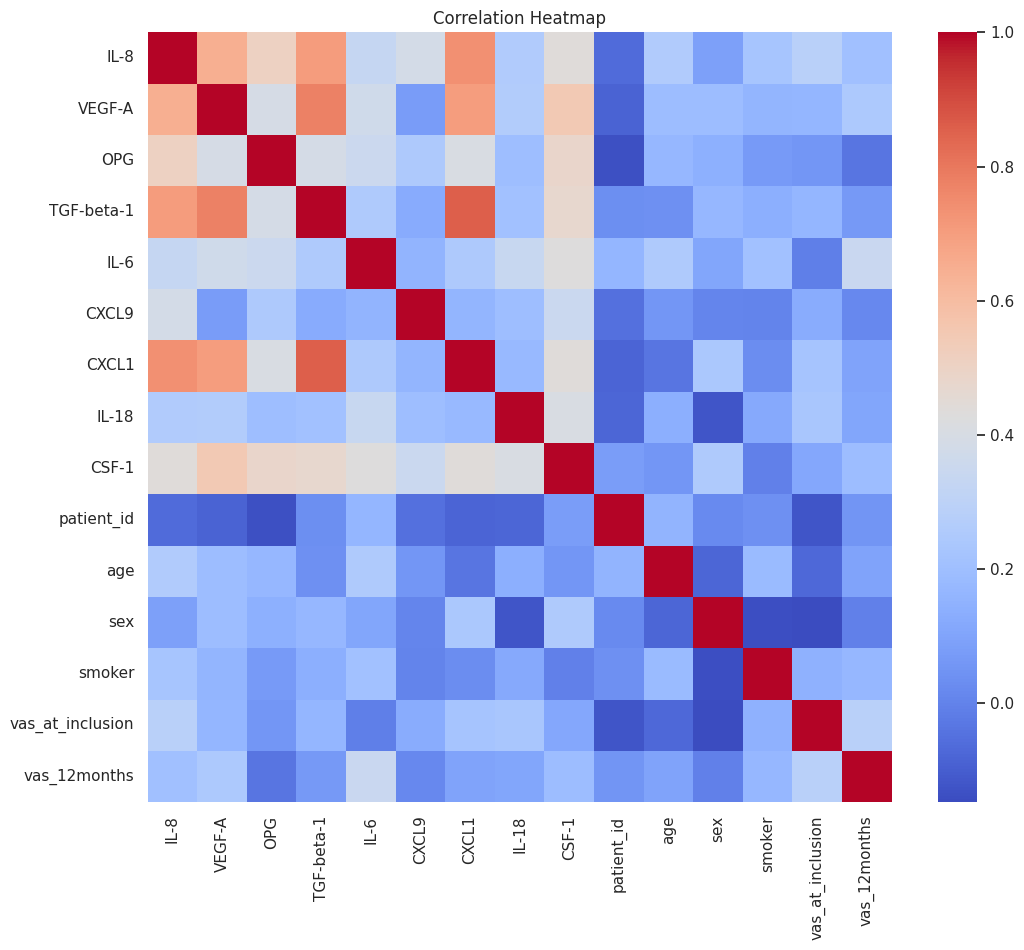

Covariance matrix:
                       IL-8    VEGF-A       OPG  TGF-beta-1      IL-6  \
IL-8              0.798470  0.389722  0.193625    0.587757  0.292785   
VEGF-A            0.389722  0.454094  0.112238    0.487044  0.248448   
OPG               0.193625  0.112238  0.180689    0.154104  0.149967   
TGF-beta-1        0.587757  0.487044  0.154104    0.863556  0.236177   
IL-6              0.292785  0.248448  0.149967    0.236177  0.996729   
CXCL9             0.308567  0.044941  0.094965    0.102659  0.138282   
CXCL1             0.818307  0.584505  0.214033    0.989477  0.308688   
IL-18             0.138302  0.107015  0.049805    0.115997  0.203155   
CSF-1             0.113592  0.107367  0.059571    0.127314  0.124298   
patient_id       -2.481007 -2.619817 -2.558291    1.368570  7.219966   
age               2.358809  1.308427  0.720595    0.377312  2.583639   
sex               0.039105  0.064032  0.030317    0.078274  0.052523   
smoker            0.095163  0.051372  0.0141

In [29]:

corr = test2.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

cov_test2 = test2[['IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 'CXCL9',
       'CXCL1', 'IL-18', 'CSF-1', 'patient_id', 'age', 'sex',
       'smoker', 'vas_at_inclusion', 'vas_12months']]
cov_matrix = cov_test2.cov(numeric_only=True)
print("Covariance matrix:\n", cov_matrix)

In [30]:


#### Prepare Data + Train/Test Split


# Outcome variable
response_var = "vas_12months"

# Predictor variables
predictor_vars = [
    "age", "sex", "smoker", "vas_at_inclusion",
    "IL-8", "VEGF-A", "OPG", "TGF-beta-1",
    "IL-6", "CXCL9", "CXCL1", "IL-18", "CSF-1"
]

X = test2[predictor_vars].copy()
y = test2[response_var].copy()

#### 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)



### Fit Linear Regression Model (OLS)

X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()

print("\n OLS Model Summary \n")
print(model.summary())

## Parameter table
params_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std_Error": model.bse,
    "t_value": model.tvalues,
    "p_value": model.pvalues,
    "CI_lower": model.conf_int()[0],
    "CI_upper": model.conf_int()[1]
})

print("\n Parameter Estimates Table ")
print(params_table)


### Training Performance

print("\n MODEL FIT (TRAINING DATA)")

y_train_pred = model.predict(X_train_sm)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Performance Metrics:")
print("RMSE:", round(train_rmse, 3))
print("MAE :", round(train_mae, 3))
print("R²  :", round(train_r2, 3))

## Model Performance on test data

print("\n EVALUATION (TEST DATA) ")

X_test_sm = sm.add_constant(X_test)
y_test_pred = model.predict(X_test_sm)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTest Performance Metrics:")
print("RMSE:", round(test_rmse, 3))
print("MAE :", round(test_mae, 3))
print("R²  :", round(test_r2, 3))



###  Prediction Intervals
pred_ci = model.get_prediction(X_test_sm).summary_frame(alpha=0.05)

print("\nPrediction Intervals (first 5 rows):")
print(pred_ci.head())


#### Summary

final_results = pd.DataFrame({
    "Actual_VAS": y_test.values,
    "Predicted_VAS": y_test_pred.values,
    "PI_lower": pred_ci["obs_ci_lower"].values,
    "PI_upper": pred_ci["obs_ci_upper"].values
})

print("\n FINAL COMBINED RESULTS (TEST SET)")
print(final_results.head(10))


Training set size: (92, 13)
Test set size: (23, 13)

 OLS Model Summary 

                            OLS Regression Results                            
Dep. Variable:           vas_12months   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     3.293
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           0.000514
Time:                        23:23:53   Log-Likelihood:                -211.41
No. Observations:                  92   AIC:                             450.8
Df Residuals:                      78   BIC:                             486.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------